In [1]:
import xgboost as xgb
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

import seaborn as sns
sns.set(font='Yu Gothic')
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [4]:
X_train = np.load("大山研XGBoost/train前半.npz")['x']
Y_train = np.load("大山研XGBoost/train前半.npz")['y']
X_test = np.load("大山研XGBoost/train後半.npz")['x']
Y_test = np.load("大山研XGBoost/train後半.npz")['y']

## グリッドサーチ

In [17]:
model = xgb.XGBClassifier(max_depth=11, min_child_weight=8, gamma=0.1, n_estimators=750, learning_rate=0.05, reg_alpha=0.5)
param = {
    # "max_depth":[9,10,11], "min_child_weight":[7,8,9]
    # "gamma":[0.01, 0.05, 0.075, 0.1]
    # "subsample":[0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00], "colsample_bytree":[0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00]
    # "n_estimators":[250, 500, 750], "learning_rate":[0.05, 0.1]
    "reg_alpha":[0.1, 0.25, 0.5, 0.75]
}
random_index = np.random.choice(np.arange(X_train.shape[0]), int(X_train.shape[0]/10)*7, replace=False)
grid = GridSearchCV(model, param_grid=param, cv=5, n_jobs=-1, scoring='f1_macro')
grid.fit(X_train[random_index], Y_train[random_index])

test_F1_Macro = grid.score(X_test, Y_test)
print("Best parameters: %s" % grid.best_params_)
print("Best Train F1_macro: %s" % grid.best_score_)
print("Test F1_macro: %s" % test_F1_Macro)

Best parameters: {'reg_alpha': 0.5}
Best Train F1_macro: 0.8091193122015069
Test F1_macro: 0.773441974154624


In [18]:
from mutagen.mp3 import MP3 as mp3
import pygame
import time
filename = '../mac_poteto.mp3' #再生したいmp3ファイル
pygame.mixer.init()
pygame.mixer.music.load(filename) #音源を読み込み
mp3_length = mp3(filename).info.length #音源の長さ取得
pygame.mixer.music.play(1) #再生開始。1の部分を変えるとn回再生(その場合は次の行の秒数も×nすること)
time.sleep(mp3_length + 0.25) #再生開始後、音源の長さだけ待つ(0.25待つのは誤差解消)
pygame.mixer.music.stop() #音源の長さ待ったら再生停止

## 訓練して、trainデータの後半をテストデータとして、評価

In [72]:
model = xgb.XGBClassifier(max_depth=10, min_child_weight=5, gamma=0.01, colsample_bytree=0.8, subsample=1.0, n_estimators=500, learning_rate=0.075, reg_alpha=0.025)
model.fit(X_train, Y_train)

predict = model.predict(X_test)

NameError: name 'cofusion_matrix' is not defined

In [188]:
class_names = ['Still(乗り物も)', 'Walking', 'Run', 'Bike']

In [186]:
def plot_confusion_matrix(test_y,pred_y,class_names,normalize=False):

    cm = confusion_matrix(test_y,pred_y)
    # classes = class_names[unique_labels(test_y,pred_y)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_names,
           yticklabels=class_names,
           ylabel='True label\n',
           xlabel='\nPredicted label')
    fmt = '.2f' if normalize else 'd'
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j,
                    i,
                    format(cm[i, j], fmt),
                    ha="center",
                    va="center",
                    color="red", fontsize=16)
    fig.tight_layout()
    return ax

In [76]:
cm = confusion_matrix(Y_test, predict)
cm

array([[162026,    615,      3,   1840],
       [  2583,  21527,    721,   6421],
       [    15,    653,   9815,    437],
       [  4219,   7146,   1665,  14906]], dtype=int64)

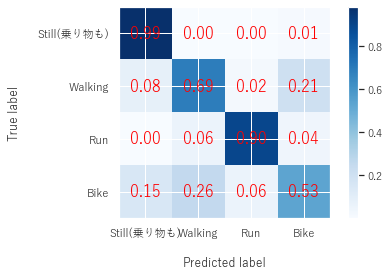

In [196]:
plot_confusion_matrix(Y_test, predict, class_names, True)
plt.show()

In [77]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(Y_test, predict)
accuracy

0.8878137361887873

In [80]:
from sklearn.metrics import f1_score
f1_macro = f1_score(Y_test, predict, average='macro')
f1_micro = f1_score(Y_test, predict, average='micro')
f1_macro, f1_micro

(0.7757694441553417, 0.8878137361887873)

## feature_importance
### f0:加速度xy平均、f1:加速度xy分散、f2:加速度z平均、f3:加速度z分散、f4:気圧変化量

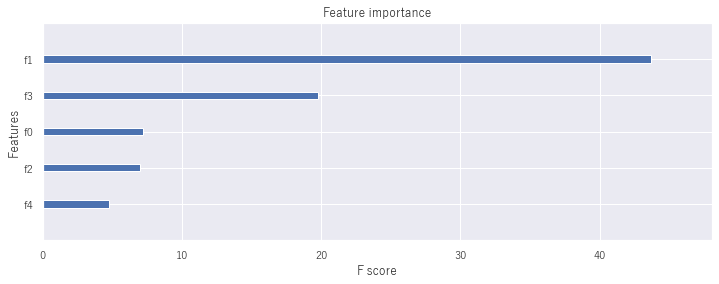

In [82]:
_, ax = plt.subplots(figsize=(12, 4))
xgb.plot_importance(model,
                    ax=ax,
                    importance_type='gain',
                    show_values=False)

## trainデータに対する評価も確認してみる

In [83]:
train_predict = model.predict(X_train)
cm = confusion_matrix(Y_train, train_predict)
cm

array([[389033,    774,      7,   2718],
       [  4481,  51750,    392,   9733],
       [    44,    719,  21748,    269],
       [  9664,  11747,    522,  43771]], dtype=int64)

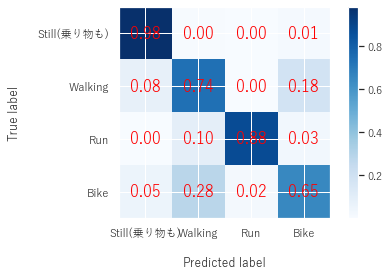

In [205]:
plot_confusion_matrix(Y_train[136843*3:136843*4], train_predict[136843*3:136843*4], class_names,normalize=True)
plt.show()

In [84]:
accuracy = accuracy_score(Y_train, train_predict)
accuracy

0.9249687598196473

In [85]:
f1_macro = f1_score(Y_train, train_predict, average='macro')
f1_macro

0.8598020352063825

# ここからValidationデータで検証

In [9]:
%%time

import pickle

with open("validation_Bag.binaryfile", 'rb') as f:
    val_Bag = pickle.load(f)[:, :, [0, 4, 5, 6, -1]]
    
with open("validation_Hips.binaryfile", 'rb') as f:
    val_Hips = pickle.load(f)[:, :, [0, 4, 5, 6, -1]]

with open("validation_Torso.binaryfile", 'rb') as f:
    val_Torso = pickle.load(f)[:, :, [0, 4, 5, 6, -1]]

with open("validation_Hand.binaryfile", 'rb') as f:
    val_Hand = pickle.load(f)[:, :, [0, 4, 5, 6, -1]]

val_Bag.shape

In [94]:
def val_Preprocess(x):
    label = x[:, 0, 0]
    label = label[:, 0]
    x_xy = np.sqrt(np.square(x[:, :, 1].copy()) + np.square(x[:, :, 2].copy()))
    x_xy_mean = np.mean(x_xy.copy(), axis=1)
    x_xy_var = np.var(x_xy.copy(), axis=1)
    x_z_mean = np.mean(x[:, :, 3].copy(), axis=1)
    x_z_var = np.var(x[:, :, 3].copy(), axis=1)
    x_pressure_change = x[:, -1, 4] - x[:, 0, -1]
    result = np.vstack([label, x_xy_mean, x_xy_var, x_z_mean, x_z_var, x_pressure_change]).T
    return result

In [95]:
val_Bag = val_Preprocess(val_Bag)
val_Hips = val_Preprocess(val_Hips)
val_Torso = val_Preprocess(val_Torso)
val_Hand = val_Preprocess(val_Hand)
val_Hand.shape

(28685, 6)

In [97]:
val_Bag[:, 0].shape

(28685,)

In [96]:
X_val = np.vstack([val_Bag[:, 1:], val_Hips[:, 1:], val_Torso[:, 1:], val_Hand[:, 1:]])
X_val.shape

((114740, 5), (4, 28685))

In [100]:
Y_val = np.hstack([val_Bag[:, 0], val_Bag[:, 0], val_Bag[:, 0], val_Bag[:, 0]])
Y_val.shape

(114740,)

In [101]:
Y_val[Y_val >=5] = 1
np.unique(Y_val)

array([1., 2., 3., 4.])

In [102]:
val_predict = model.predict(X_val)

In [103]:
cm = confusion_matrix(Y_val, val_predict)
cm

array([[81585,   193,    50,   348],
       [ 5892,  9115,    14,  5739],
       [   40,   949,   596,   619],
       [ 7228,  1070,     1,  1301]], dtype=int64)

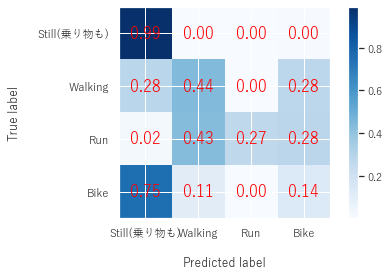

In [201]:
plot_confusion_matrix(Y_val, val_predict, class_names, True)

In [104]:
accuracy = accuracy_score(Y_val, val_predict)
accuracy

0.8070158619487537

In [105]:
f1_macro = f1_score(Y_val, val_predict, average='macro')
f1_macro

0.5135642210585022

# ユーザごとの平均の分布を出す

In [2]:
X_val = np.load("大山研XGBoost/validation.npz")['x']

In [3]:
val_size = X_val.shape[0]//4

In [5]:
hold_positions = ['Bag', 'Hips', 'Torso', 'Hand']

def hist_plot(sensor):
    plt.figure(figsize=(24, 8))

    plt.subplots_adjust(wspace=0.4, hspace=0.2)

    for i in range(4):
        plt.subplot(1, 4, i+1)
        sns.distplot(X_train[136843*i:136843*(i+1), sensor], bins=21, label='train_' + hold_positions[i])
        sns.distplot(X_val[val_size*i:val_size*(i+1), sensor], bins=21, label='val_' + hold_positions[i])
        plt.legend()
    plt.show()



## 世界標準座標系加速度XY合成平均ヒストグラム

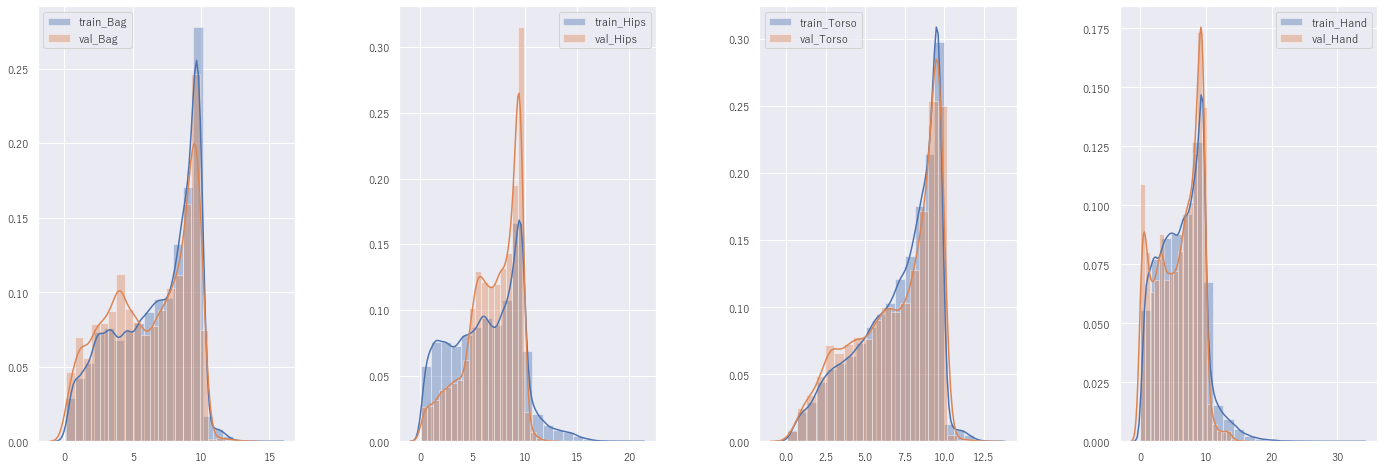

In [6]:
hist_plot(0)

## 世界標準座標系加速度Z平均ヒストグラム

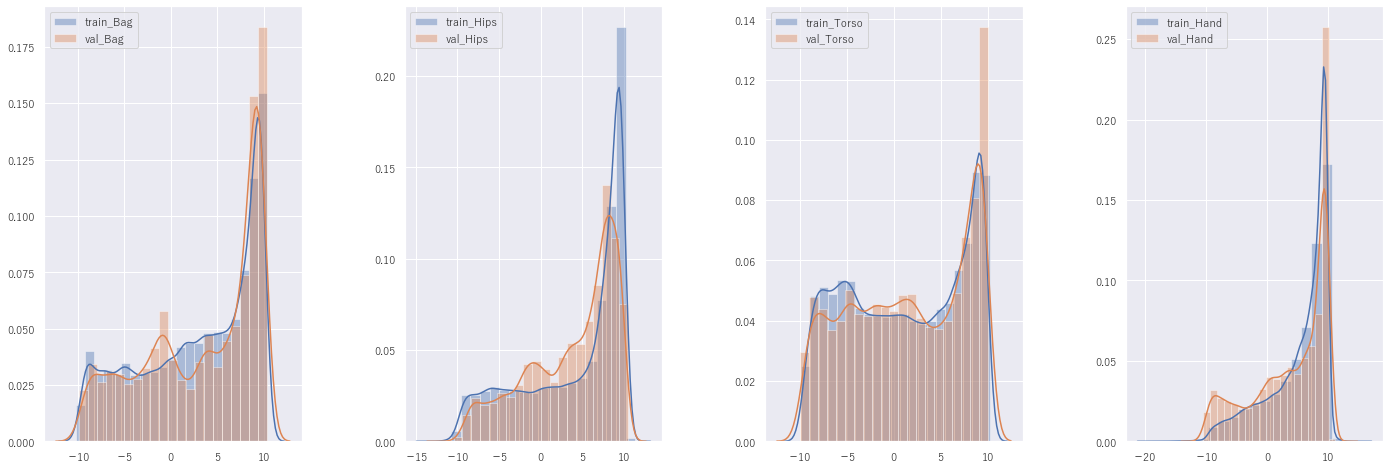

In [7]:
hist_plot(2)

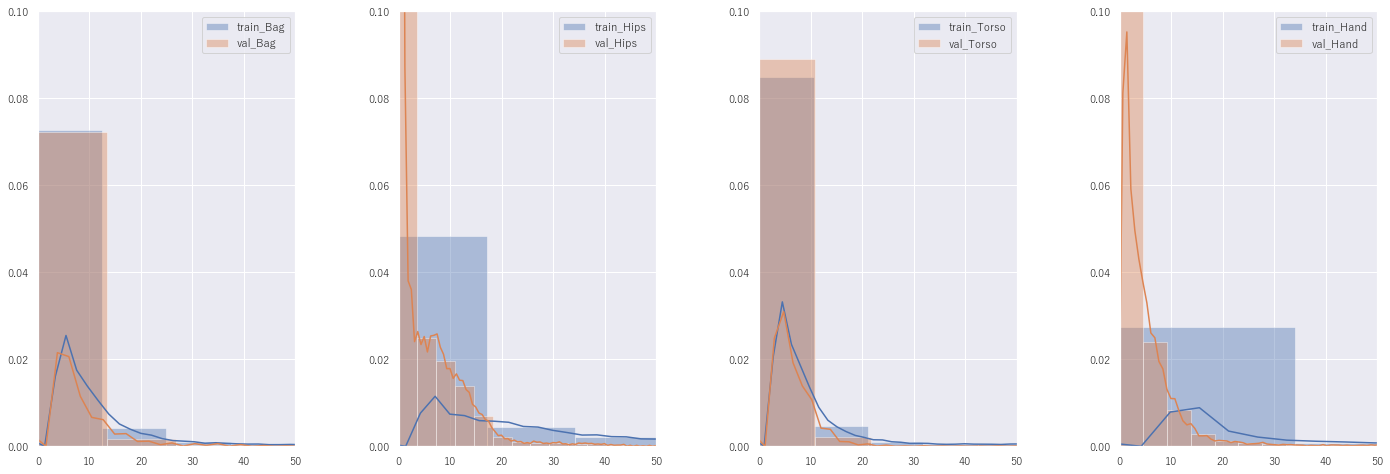

In [10]:
def hist_plot(sensor):
    plt.figure(figsize=(24, 8))

    plt.subplots_adjust(wspace=0.4, hspace=0.2)

    for i in range(4):
        plt.subplot(1, 4, i+1)
        sns.distplot(X_train[136843*i:136843*(i+1), sensor], bins=21, label='train_' + hold_positions[i])
        sns.distplot(X_val[val_size*i:val_size*(i+1), sensor], bins=21, label='val_' + hold_positions[i])
        plt.xlim(0, 50)
        plt.ylim(0, 0.1)
        plt.legend()
    plt.show()

hist_plot(1)

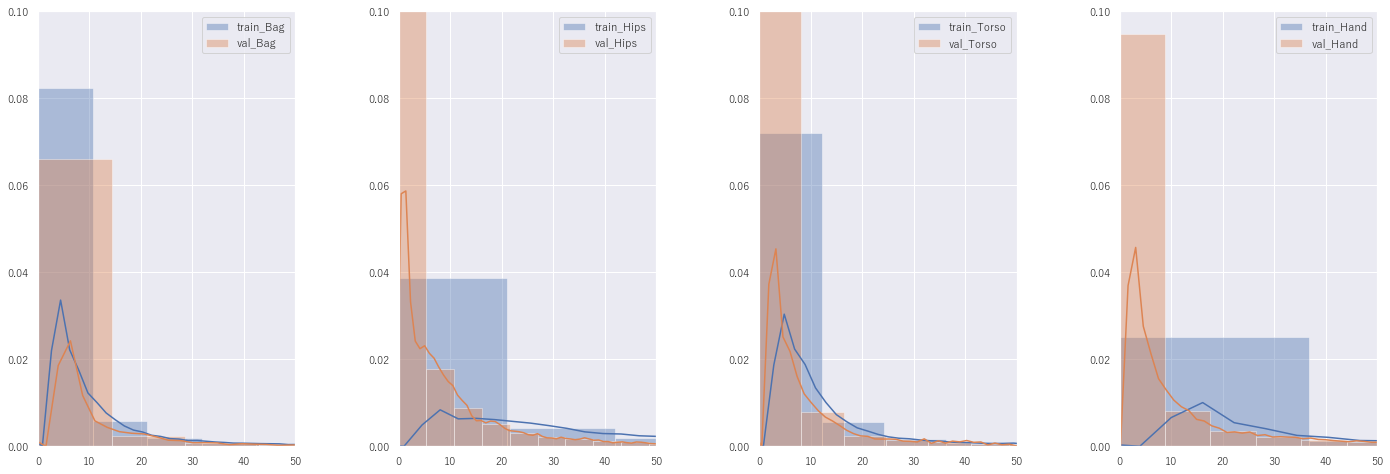

In [11]:
hist_plot(3)

In [11]:
%reset

In [12]:
import xgboost as xgb
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

import seaborn as sns
sns.set(font='Yu Gothic')
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [13]:
def lacc_read(hold_position):
    label = np.load("train_" + hold_position + "/train_" + hold_position + "_Label.npy")
    lacc = np.load("train_" + hold_position + "/train_" + hold_position + "_LAcc.npy")
    result = np.concatenate([label, lacc], axis=2)
    del label, lacc
    return result

In [14]:
X_Bag = lacc_read("Bag")
X_Hips = lacc_read("Hips")
X_Torso = lacc_read("Torso")
X_Hand = lacc_read("Hand")

X_Bag.shape

(195491, 500, 4)

In [15]:
def save_npy(x, hold_position):
    x_label = x[:, 0, 0]

    x_lacc_xy = np.sqrt(np.square(x[:, :, 1]) + np.square(x[:, :, 2]))
    x_lacc_xy_mean = np.mean(x_lacc_xy, axis=1)
    x_lacc_xy_var = np.var(x_lacc_xy, axis=1)
    x_lacc_z_abs = np.abs(x[:, :, 3])
    x_lacc_z_mean = np.mean(x_lacc_z_abs, axis=1)
    x_lacc_z_var = np.var(x_lacc_z_abs, axis=1)

    result = np.concatenate([x_label.reshape(-1, 1), x_lacc_xy_mean.reshape(-1, 1), x_lacc_xy_var.reshape(-1, 1), x_lacc_z_mean.reshape(-1, 1), x_lacc_z_var.reshape(-1, 1)], axis=1)
    del x_label, x_lacc_xy, x_lacc_xy_mean, x_lacc_xy_var, x_lacc_z_abs, x_lacc_z_mean, x_lacc_z_var
    return result

In [16]:
X_Bag = save_npy(X_Bag, "Bag")

X_Bag.shape

(195491, 5)

In [17]:
X_Hips = save_npy(X_Hips, "Hips")
X_Torso = save_npy(X_Torso, "Torso")
X_Hand = save_npy(X_Hand, "Hand")

X_Hand.shape

(195491, 5)

In [18]:
import pickle

validation_Bag = pickle.load(open("validation_Bag.binaryfile", 'rb'))
validation_Hips = pickle.load(open("validation_Hips.binaryfile", 'rb'))
validation_Torso = pickle.load(open("validation_Torso.binaryfile", 'rb'))
validation_Hand = pickle.load(open("validation_Hand.binaryfile", 'rb'))

validation_Bag.shape

(28685, 500, 24)

In [19]:
validation_Bag = validation_Bag[:, :, [0, 13, 14, 15]]
validation_Hips = validation_Hips[:, :, [0, 13, 14, 15]]
validation_Torso = validation_Torso[:, :, [0, 13, 14, 15]]
validation_Hand = validation_Hand[:, :, [0, 13, 14, 15]]

validation_Bag.shape

(28685, 500, 4)

In [20]:
validation_Bag = save_npy(validation_Bag, "Bag")
validation_Hips = save_npy(validation_Hips, "Hips")
validation_Torso = save_npy(validation_Torso, "Torso")
validation_Hand = save_npy(validation_Hand, "Hand")

validation_Bag.shape

(28685, 5)

In [21]:
X_train = np.concatenate([X_Bag[:, 1:], X_Hips[:, 1:], X_Torso[:, 1:], X_Hand[:, 1:]], axis=0)
Y_train = np.concatenate([X_Bag[:, 0], X_Hips[:, 0], X_Torso[:, 0], X_Hand[:, 0]], axis=0)
Y_train[Y_train >= 5] = 1

X_train.shape, Y_train.shape

((781964, 4), (781964,))

In [22]:
X_val = np.concatenate([validation_Bag[:, 1:], validation_Hips[:, 1:], validation_Torso[:, 1:], validation_Hand[:, 1:]], axis=0)
Y_val = np.concatenate([validation_Bag[:, 0], validation_Hips[:, 0], validation_Torso[:, 0], validation_Hand[:, 0]], axis=0)
Y_val[Y_val >= 5] = 1

X_val.shape, Y_val.shape

((114740, 4), (114740,))

In [24]:
model = xgb.XGBClassifier(learning_rate=0.1)
param = {
    "max_depth":[6, 7, 8], "min_child_weight":[10, 12, 14, 16]
    # "gamma":[0.01, 0.05, 0.075, 0.1]
    # "subsample":[0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00], "colsample_bytree":[0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00]
    # "n_estimators":[250, 500, 750], "learning_rate":[0.05, 0.1]
    # "reg_alpha":[0.1, 0.25, 0.5, 0.75]
}
grid = GridSearchCV(model, param_grid=param, cv=5, n_jobs=5, scoring='f1_macro')
grid.fit(X_train, Y_train)

test_F1_Macro = grid.score(X_val, Y_val)
print("Best parameters: %s" % grid.best_params_)
print("Best Train F1_macro: %s" % grid.best_score_)
print("Test F1_macro: %s" % test_F1_Macro)